This project will compare observational data from <a href="#refs">Hughes et al. (2018)</a> with results from a numerical model <a href="#refs">(Logan et al., 2018)</a>.  Each dataset is global, but the scales and coverage vary widely.  As a shorthand, I will refer to the 100 locations in the former as "Hughes reef areas" and the 1,925 locations in the latter as "Logan reef cells".

The goal is to evaluate the utility of using the Hughes data to validate or calibrate the Logan model.  The Logan model, based on <a href="#refs">(Logan et al., 2014)</a>, is not intended to model the details of individual reefs, but rather to show trends which are useful in evaluating the effect of different climate scenarios or in comparing the likely effect of human interventions to protect corals.  Thus a reef-by-reef comparison is not expected to be exact, but I want see how much correlation there is, both reef-by-reef and regionally, between the two datasets.

The following notebook has several sections.
1. Data input and display of raw data
    + <a href="#HughesData">Hughes</a>
    + <a href="#LoganData">Logan</a>
2. Matching of Hughes reef areas to Logan reef cells
3. Map-based comparison of the datasets
4. Principal component analysis to look for variables by which to group reefs
5. Scatterplot comparisons of pertinent variables
6. Scatterplot comparisons of Hughes and Logan reef-by-reef data
7. Comparison of world and regional bleaching totals over time

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import cartopy.crs as ccrs

from coral_project_functions import make_coral_map

# Read data from the Hughes supplemental material.  The first
# sheet is a cut-and-paste from their document with obvious typos
# fixed by hand and a few columns added for easier data manipulation.
# The second sheet has been arranged for easier import.
filename = '../data/Hughes100Reefs.xlsx' 
hughes = pd.read_excel(filename,header=0,sheet_name=1, na_values='-')
# Missing size values are set to zero - be careful how they are used later!
# hughes.Size_km2 = hughes.Size_km2.replace({"-": "0"})

<a id="HughesData"></a>
## Columns from Hughes et al. are
1. Hughes Reef - the index used in their data, 1-100.
2. Region - my code for their region labels.
    + AuA - Australasia
    + IO-ME - Indian Ocean/ Middle East
    + Pac - Pacific
    + WAtl - West Atlantic
3. Location - their location name for each reef. 
4. Numeric Lat - decimal values between about -35 and +35
5. Numeric Lon - decimal values between -180 and +180
6. Size_km2 - area in square kilometers, sometimes omitted.
7. Year - columns 7 to 43 - one column for each year of data, 1980 to 2016.  Values are blank, S, or M.
44. Severe count - the count of the number of cells in this row with the entry "S". values 0-7
45. Moderate count - the count of the number of cells in this row with the entry "M".  Values 0-12

In [5]:
# Now read our data for reef cell locations.
import scipy.io as sio

# Reference for all data for the 1,925 reef cell model.
# This has not been submitted to a journal yet, so all is subject to change:
#
# Logan, C. A., Dunne, J. P., Ryan, J. S., Baskett, M. L. & Donner, S. D. Can symbiont
# diversity and evolution allow corals to keep pace with global warming
# and ocean acidification? prep (2018).

# A copy of the data is in this repository.  The reference copy is in
# my Coral-Model-Data repository in the ProjectionsPaper directory.
mat_data = sio.loadmat('../data/ESM2M_SSTR_JD.mat')
# Put just the lat/lon columns into a data frame.  Note that they are stored
# with longitude first in the incoming data.
cells = pd.DataFrame(mat_data['ESM2M_reefs_JD'], columns=['Lon', 'Lat'])
# del mat_data  # this gets garbage collected, saving around 200 MB.

# Next, read the bleaching counts from a MATLAB mat file written for this purpose.
mat_data = sio.loadmat('../data/HughesCompEvents_selV_rcp60E=1OA=1.mat')
# Put the bleaching counts into a data frame.  These counts are the total for each
# reef during 1980 to 2016.
modelBleaching = pd.DataFrame(mat_data['events80_2016'])
modelBleaching.rename(columns={0: 'Events'}, inplace=True)
# Be we really want this in the cells dataframe
cells['Events'] = modelBleaching['Events']

# For later use, also load the un-summarized data which has the bleaching
# flags for each reef and year from 1980 to 2016.  Branching and massive coral
# are treated separately.
massive_bleach = np.array(mat_data['events80_2016_detail'][:, :, 0])
branching_bleach = np.array(mat_data['events80_2016_detail'][:, :, 1])

del mat_data
del modelBleaching
cells.head()

,Lon,Lat,Events
0,-179.5,-19.145246,2
1,-179.5,-18.311912,2
2,-179.5,-17.500333,2
3,-179.5,-16.710136,1
4,-179.5,-15.940584,1


<a id="LoganData"></a>
## Columns from the Logan et al. data are
For each cell:
1. Lat - the latitude of the centroid
2. Lon - the longitude of the centroid
3. Events - the number of bleaching events between 1980 and 2016, inclusive

<IPython.core.display.Javascript object>


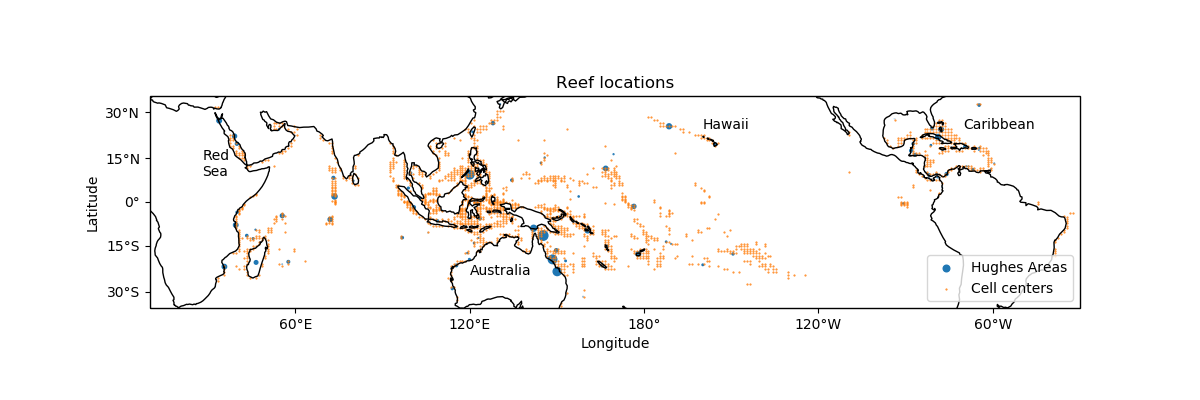

In function, extent =  [10, 330, -35, 35]
Area size min/max/mean/median: 2.0 9319.0 945.1030927835052 343.0 km^2


Text(20,25,'Hawaii')

In [7]:
plt.figure(figsize=[12, 4])
ax = make_coral_map()
# Hughes reef areas can be large.  Make size proportional.  Conveniently, the marker
# size argument is in square units.  However, our map is in degree units and the areas
# are in kilometers.  This is a rough conversion relating pixels to square degrees.
conversion = 60*(1/111)**2
area_sizes = hughes.Size_km2.astype(float)
# Do some stats with no NaN values
sss = area_sizes[~np.isnan(area_sizes)]
print("Area size min/max/mean/median:", min(sss), max(sss), np.mean(sss), np.median(sss), 'km^2')

lon = hughes['Numeric Lon']
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o',
            s=conversion*area_sizes,
            label='Hughes Areas', transform=ccrs.PlateCarree())
# Mark our cells with small dots.
lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], marker='.', s=1, label='Cell centers',
           transform=ccrs.PlateCarree())
plt.title('Reef locations')
plt.legend()
plt.text(110, 25, 'Caribbean')
plt.text(-60, -25, 'Australia')
plt.text(-152, 9, 'Red\nSea')
plt.text(20, 25, 'Hawaii')

<IPython.core.display.Javascript object>


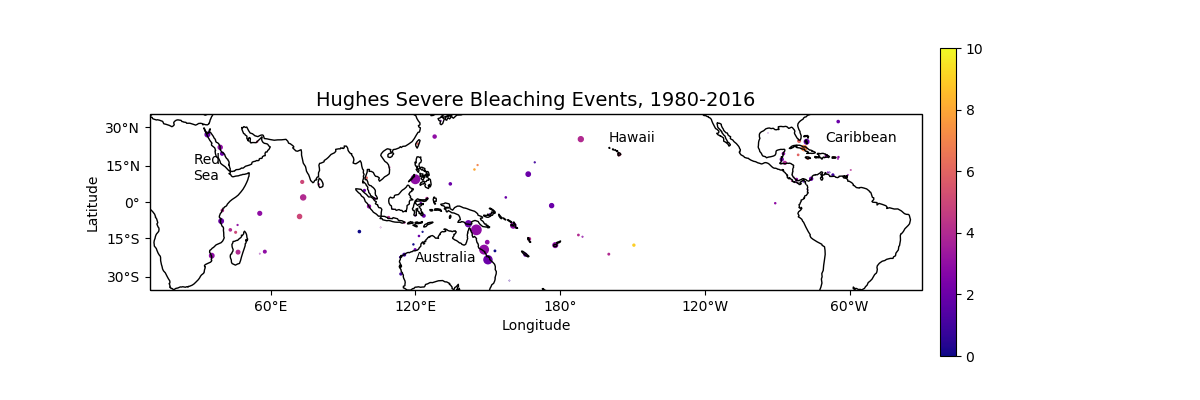

In function, extent =  [10, 330, -35, 35]


Text(20,25,'Hawaii')

In [8]:
# Now try an indication of bleaching severity.
plt.figure(figsize=[12, 4])
ax = make_coral_map()
lon = hughes['Numeric Lon']
severity = hughes['Severe count']
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o', 
            s=conversion*area_sizes,
            label='Hughes Areas',
            c=severity,
            cmap="plasma",
            transform=ccrs.PlateCarree())

plt.title('Hughes Severe Bleaching Events, 1980-2016', fontsize=14)
plt.clim(0, 10)
plt.colorbar(pad=0.02)
plt.text(110, 25, 'Caribbean')
plt.text(-60, -25, 'Australia')
plt.text(-152, 9, 'Red\nSea')
plt.text(20, 25, 'Hawaii')

<IPython.core.display.Javascript object>


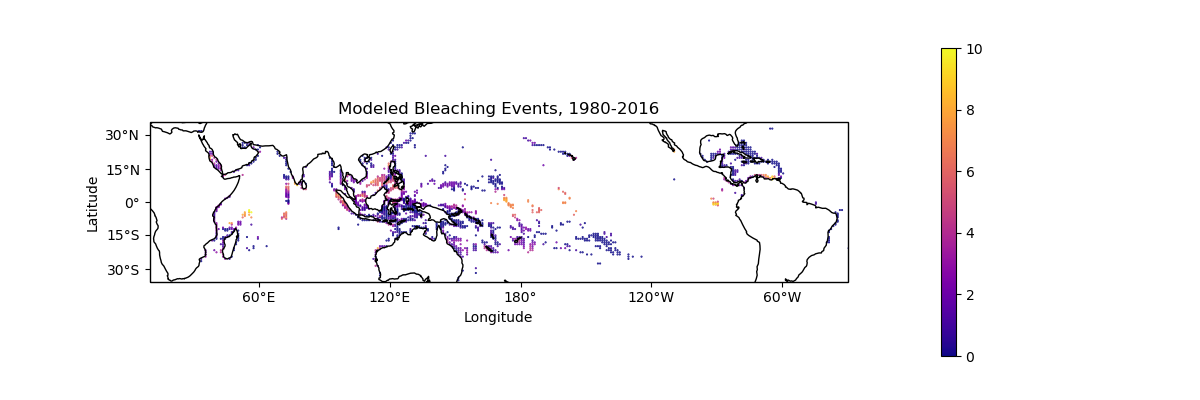

In function, extent =  [10, 330, -35, 35]


In [9]:
# Look at Bleaching events from the numerical model, using the same scale as
# the previous plot of Hughes data.
plt.figure(figsize=[12, 4])
ax = make_coral_map()

lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], c = cells['Events'],
            marker='.', s=1, label='Events', cmap="plasma",
            transform=ccrs.PlateCarree())
plt.title('Modeled Bleaching Events, 1980-2016')
plt.clim(0, 10)
plt.colorbar(pad=0.10);

In [10]:
cells.head()

,Lon,Lat,Events
0,-179.5,-19.145246,2
1,-179.5,-18.311912,2
2,-179.5,-17.500333,2
3,-179.5,-16.710136,1
4,-179.5,-15.940584,1


In [11]:
hughes.head()

,Hughes Reef,Region,Location,Numeric Lat,Numeric Lon,Size_km2,1980,1981,1982,1983,...,2009,2010,2011,2012,2013,2014,2015,2016,Severe count,Moderate count
0,1,AuA,"Australia, Coral Sea Northern",-16.5,149.8,1165.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,1
1,2,AuA,"Australia, Coral Sea Southern",-20.0,153.0,231.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,0,1
2,3,AuA,"Australia, GBR Central",-19.5,148.5,7735.0,M,NaN,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,5
3,4,AuA,"Australia, GBR Northern",-11.5,145.3,9319.0,M,NaN,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,2
4,5,AuA,"Australia, GBR Southern",-23.5,150.1,6872.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2,2


In [12]:
# To make a fair comparison, we need to figure out which of our cells match Hughes reef areas.
# Each area has a center and an area, so we can use a circle of that area as a first-order guess.
# Unfortunately, it seems that the areas are quite warped, because some of the centers are far
# inland.

# Use scipy.spatial.cKDTree to find neighbors.
from scipy import spatial
# Build the tree (a binary trie) of our cells.
# NOTE: cells.as_matrix({'Lon', 'Lat'}) does not return the columns in a determinate order!
# explicitly stack the columns instead.
lonlat = np.column_stack((cells['Lon'], cells['Lat']))
tree = spatial.cKDTree(lonlat)

# For each of the 100 Hughes cells, get a list of our cells which are likely to overlap.
# I failed to find a way to add variable-length lists to a column, so the lists are stored
# separately.
hughes = hughes.assign(radius_km=hughes.Size_km2**0.5)
cell_lists = [[] for i in range(len(hughes))]
match_idx = np.zeros(len(hughes), dtype=np.bool)
for i in range(len(hughes)):
    # convert radius to degrees (ignoring change of size with latitude for now)
    # also, add 0.5 degrees as a rough allowance for our cell size
    # radius = 0.5 + hughes.radius_km[i] / 111
    radius = 0.5 + hughes.radius_km[i] / 111
    c = tree.query_ball_point([hughes['Numeric Lon'][i], hughes['Numeric Lat'][i]],
                              radius, n_jobs=2)
    # Convert zero-based indexes to 1-based cell numbers.
    cell_lists[i] = [x+1 for x in c]
    match_idx[i] = len(c) > 0

print(cell_lists)

# Hughes et al. assigns each reef area to a region.  Repeat the use of the tree with
# a large enough radius that each cell is matched to some Hughes area, and store the
# area name in the cell dataframe.  This allows us to assign each cell to a region.
# To increase the odds of high quality matches, this will be run at a small radius
# first, which then increased.  Matches found at a small radius will not be overwritten
# by matches at a large radius.
cells = cells.assign(Region='none')
cells_assigned = 0
r = 0.5
while cells_assigned < 1925:
    for i in range(len(hughes)):
        # 0 gives 15 comparisons, 0.5 gives 76, 2.0 gives 93.  In all cases there's an
        # insignificant negative correlation in bleaching.
        radius = r + hughes.radius_km[i] / 111
        c = tree.query_ball_point([hughes['Numeric Lon'][i], hughes['Numeric Lat'][i]],
                                  radius, n_jobs=-1)
        # Convert zero-based indexes to 1-based cell numbers.
        region = hughes.Region[i]
        #print('Reef', i, 'region', region, 'found ', c)
        for x in c:
            if cells.loc[x, 'Region'] == 'none':
                cells.loc[x, 'Region'] = region
                cells_assigned = cells_assigned + 1
    print('After r =', r, ',', cells_assigned, 'are assigned.')
    r = r * 2

# Some special cases are mis-identified with the approach above.
# South atlantic, off Brazil is initially id'd as Indian Ocean/ Middle East!
# Make a bounding box to specify these cells
box = [-40, -25, -26, -16]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
# Others off Brazil are labeled Pacific.
box = [-39, -34, -16, -8]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
# Some SW Caribbean cells are id'd as Pacific
box = [-83, -80,  12, 16]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
box = [-81, -76, 8.8, 11]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"

print('Pacific:', sum(cells['Region'] == 'Pac'))
print('Indian Ocean - Middle East:', sum(cells['Region'] == 'IO-ME'))
print('Australasia:', sum(cells['Region'] == 'AuA'))
print('West Atlantic:', sum(cells['Region'] == 'WAtl'))
cells.to_pickle('../results/Logan_cells_events_region.pkl')
cells.head()

[[1601, 1602, 1624], [], [1597, 1578, 1560, 1579, 1598], [1513, 1512, 1528], [], [991], [1738], [], [961], [], [], [1679], [], [1496], [], [994, 993], [1198, 1197], [915], [935], [1267, 1268], [1093, 1126], [1232, 1233], [813, 812, 814], [], [1357, 1342], [831], [1630, 1631, 1652], [1107, 1108, 1136, 1135, 1137], [1759, 1758, 1766], [], [807, 808], [], [1181, 1225], [851], [762, 763], [1086], [1147, 1148], [656, 665, 657, 666], [553], [], [680, 706], [516, 517], [], [], [695, 696, 697], [636, 635], [565, 566], [476, 477], [502], [487, 488], [624, 625], [572], [], [], [492, 493, 494], [], [71], [], [1540], [103], [275], [], [1906, 1912, 1913], [144], [240, 241, 239], [1525, 1524], [126], [70, 73], [], [1903, 1904], [], [1785, 1786], [1457, 1458], [], [], [1811, 1810, 1827, 1828], [57], [1798, 1818], [342, 331, 343], [445], [258], [422], [402], [420], [301], [348], [], [329], [398, 402], [399], [311, 304], [224], [256, 265, 266], [338, 339], [260, 261], [283, 296], [], [419], [441, 440],

,Lon,Lat,Events,Region
0,-179.5,-19.145246,2,Pac
1,-179.5,-18.311912,2,Pac
2,-179.5,-17.500333,2,Pac
3,-179.5,-16.710136,1,Pac
4,-179.5,-15.940584,1,Pac


In [13]:
# Now that we have a correspondence between Hughes areas and Logan cells, we can
# compare the bleaching for those which have some overlap.
# Add a column for cell-based bleaching values
hughes = hughes.assign(cell_bleach=np.zeros(len(hughes)))
for i in range(len(hughes)):
    if len(cell_lists[i]) > 0:
        count = 0;
        for n in cell_lists[i]:
            # "n-1" because cells are 1-based and modelBleaching is 0-based
            count = count + cells.loc[n-1, 'Events']
        hughes.loc[i, 'cell_bleach'] = count / len(cell_lists[i])


<IPython.core.display.Javascript object>


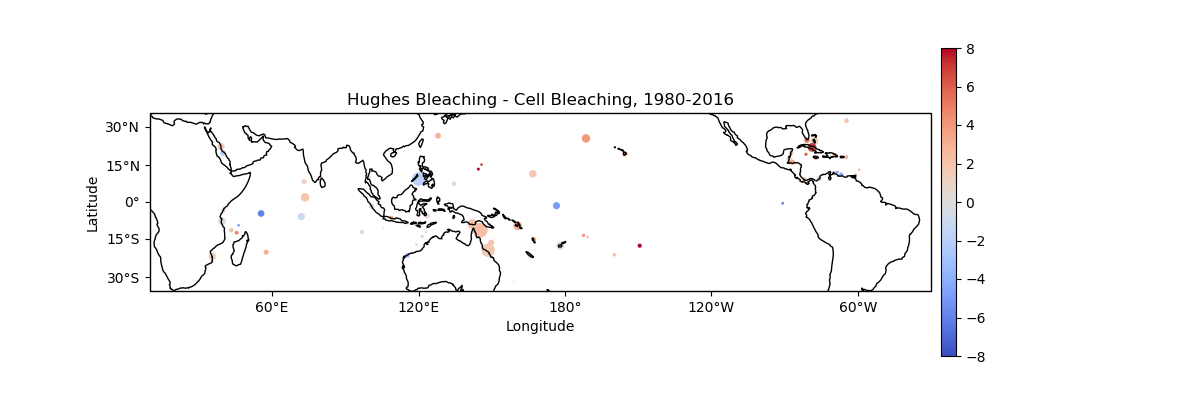

In function, extent =  [10, 330, -35, 35]
There are 76 areas with comparisons.


In [14]:
# Plot the Hughes reefs, but only those which have Logan cells to compare to.
# Color the markers by the ratio between the two bleaching values.
plt.figure(figsize=[12, 4])
ax = make_coral_map()

conversion = 120*(1/111)**2
lon = hughes[match_idx]['Numeric Lon']

print("There are", len(lon), "areas with comparisons.")
severity = hughes[match_idx]['Severe count'] - hughes[match_idx]['cell_bleach']
# Both zero counts as a ratio of 1.
severity[np.isnan(severity)] = 1  
# Divide by zero is arbitrarily 12.  FIND A BETTER COMPARISON!
severity[np.isinf(severity)] = 12
plt.scatter(lon, hughes[match_idx]['Numeric Lat'], marker='o', 
            s=conversion*hughes[match_idx].Size_km2.astype(float),
            label='Hughes Areas',
            c=severity,
            cmap='coolwarm',
            transform=ccrs.PlateCarree())

plt.title('Hughes Bleaching - Cell Bleaching, 1980-2016')
plt.clim(-8, 8)
plt.colorbar(pad=0.01)

In [ ]:
# That doesn't look great.  What is the correlation?
from coral_project_functions import bleach_scatter

h_match = hughes[match_idx]   
bleach_scatter(hughes[match_idx], 'World')

In [ ]:
# Now see if he correlation is better regionally.
h_match_region = h_match[h_match['Region'] == 'Pac']
bleach_scatter(h_match_region, 'Pacific')

In [ ]:
# Examine the two upper left points
print(h_match_region[h_match_region['cell_bleach'] > 6])

### Outlier notes
The two outlying locations are in the Galapagos and Kiribati, to use their Hughes names.  
Galapagos has a land area of around 7000 $km^2$ and Hughes has a reef area of 126 $km^2$.
Kiribati has a land area of 800 $km^2$ (wikipedia) and Hughes has a reef area of 1718 $km^2$.
While Kiribati is closer to the Galapagos than most Pacific islands and they are both
equatorial, they are quite far apart (over 90 deg longitude) and there is little reason
to group them.

In [ ]:
h_match_region = h_match[h_match['Region'] == 'WAtl']
bleach_scatter(h_match_region, 'Atlantic')

In [ ]:
# Examine the three upper left points
print(h_match_region[h_match_region['cell_bleach'] > 4])

### Outlier notes
The three outlying locations are Bonaire, Curacao, and Venezuela, to use their Hughes names.  
Curacao has a land area of 444 $km^2$ (Wikipedia) and Hughes has a reef area of 47 $km^2$.
Bonaire has a land area of 295 $km^2$ (wikipedia) and Hughes has a reef area of 22 $km^2$.
Venezuela is continental, and the Hughes are is 349 $km^2$, perhaps corresponding to the Gran Roque reef east of Bonaire.
It is interesting that these outliers are adjacent, and have low bleaching according to Hughes and higher bleaching in our model.
Repeating the plot with these three locations removed only decreases the $R^2$ value, and the slope is still negative.

In [ ]:
h_match_region = h_match[h_match['Region'] == 'AuA']
bleach_scatter(h_match_region, 'Australasia')

In [ ]:
h_match_region = h_match[h_match['Region'] == 'IO-ME']
bleach_scatter(h_match_region, 'Indian Ocean - Middle East')

## Another subset approach - by size
Plot this same comparison using only the smallest and only the largest reef areas, based on Hughes


In [ ]:
median_area = np.median(h_match['Size_km2'])
h_match_big = h_match[h_match['Size_km2'] >= median_area]
h_match_small = h_match[h_match['Size_km2'] < median_area]

# Biggest half
bleach_scatter(h_match_big, 'Large areas')

# Smallest half
bleach_scatter(h_match_small, 'Small areas')

## Another approach
Perhaps reefs will simply not correlate on an individual basis, but the cumulative bleaching in an area is of interest.  Go back to using the hughes and cells arrays without regard to individual matches.  The plot below is scale to show the same number of total events.

In [ ]:
# Make the same plots using a function
from coral_project_functions import bleach_annual_plot

# The annual bleaching count for the whole world, based on Logan et al. (2018)
plt.figure(figsize=[9, 6])
bleach_annual_plot(branching_bleach, massive_bleach, hughes, 'World')



#shiftYear = -1.5
#plt.plot(range(1980, 2017), hughes_norm, label='Hughes')
#plt.plot(shiftYear+np.array(range(1980, 2017)), cell_norm, label='Logan')
#plt.legend()

In [ ]:
# Now do the same thing for each region separately.
plt.figure(figsize=[9, 6])
plt.subplot(2,2,1)
c_idx = cells['Region'] == 'AuA'
h_idx = hughes['Region'] == 'AuA'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Australasia', True)

plt.subplot(2,2,2)
c_idx = cells['Region'] == 'Pac'
h_idx = hughes['Region'] == 'Pac'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Pacific', True)

plt.subplot(2,2,3)
c_idx = cells['Region'] == 'IO-ME'
h_idx = hughes['Region'] == 'IO-ME'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Indian Ocean - Middle East', True)


plt.subplot(2,2,4)
c_idx = cells['Region'] == 'WAtl'
h_idx = hughes['Region'] == 'WAtl'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Western Atlantic - Caribbean', True)

plt.subplots_adjust(hspace=0.8, wspace=0.3)


## Interpretation of cumulative bleaching
1. The curves have been scaled to reach the same endpoint.  Only the rate of increase over time is of interest.
2. The model SST data matches the typical frequency of events such as El Nino, but not the exact timing, so the exact dates of jumps is not comparable.
3. This really should be repeated with actual historical temperatures, but I only fully appreciated that on May 7.  It is unlikely that I can obtain and scale appropriate data before the due date.

<a id='refs'></a>
References

Hughes, T. P. et al. Spatial and temporal patterns of mass bleaching of corals in the Anthropocene. Science 359, 80–83 (2018).

Logan, C. A., Dunne, J. P., Ryan, J. S., Baskett, M. L. & Donner, S. D. Can symbiont diversity and evolution allow corals to keep pace with global warming and ocean acidification? prep (2018).

Logan, Cheryl A., John P. Dunne, C. Mark Eakin, and Simon D. Donner. 2014. “Incorporating Adaptive Responses into Future Projections of Coral Bleaching.” Global Change Biology 20 (1):125–39. https://doi.org/10.1111/gcb.12390.